In [336]:
import pandas as pd
import requests
from lxml import html
from bs4 import BeautifulSoup
import random
from collections import Counter
import re
from pymorphy2 import MorphAnalyzer
import time
from tqdm import tqdm
import numpy as np
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
pd.options.mode.chained_assignment = None  # Disable SettingWithCopyWarning

В текущее время в России очень сложно проводить исследования. Когда дело касается острых и актуальных вопросов, люди предпочитают давать безопасные и социально ожидаемые ответы. Поэтому поиск дополнительных инструментов измерения общественных настроений является, на мой взгляд, важной задачей. Википедия — это общедоступная энциклопедия со свободным контентом. Разместить статью там может, кто угодно, опираясь на актуальные события и темы, которые авторы считают важным осветить. Я решила посмотреть, как изменился контент за несколько лет, что волнует русскоязычный сегмент энциклопедии и как википедия может помочь понять мысли и настроения людей. 

За основу я взяла страницы, которые являются титульными для определённого года. Список слов ограничила существительными, а так же добавила в исключения часто встречающиеся слова, которые не являются контентом, а помогают пользователям навигироваться по энциклопедии, так же исключила названия месяцев и дней недели, которые будут только создавать информационный шум. Далее отобрала топ 300 слов для 4 лет (2013, 2016, 2019 и 2022) и визуализировала при помощи облака. Хотелось охватить десятилетие, чтобы захватить не только последние события.

In [200]:
# список слов исключений
stopword = ['год', 'википедия', 'материал', 'энциклопедия', 'навигация', 'поиск', 'статья', 'часть', 'информация', 'событие',
             'десятилетие', 'век', 'тысячелетие', 'календарь', 'январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль', 
             'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь', 'января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 
             'июля', 'августа', 'сентября', 'октября', 'ноября', 'декабря', 'содержание', 'код', 'викимедиа', 
             'конфиденциальность', 'описание', 'версия', 'разработчик', 'кук', 'долл', 'евро', 'тысяча', 'число', 'воскресенье', 'понедельник', 
             'вторник', 'среда', 'четверг', 'пятница', 'суббота', 'месяц', 'дата', 'день', 'также', 'примечание',
             'отсутствие', 'неопр', 'англ', 'ссылка', 'источник', 'архив', 'копия', 'оригинал', 'обращение', 'сноска', 
             'сайт', 'название', 'раздел', 'модуль', 'редактор', 'страница', 'шаблон', 'период','служба','новость']

In [95]:
# изображение, которое будет определять форму облака слов
mask = np.array(Image.open('https://e7.pngegg.com/pngimages/106/199/png-clipart-flag-of-russia-map-russia-flag-leaf.png'))

In [152]:
mask

array([[2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1]], dtype=uint8)

In [102]:
# задаю белый фон (меняю в массиве 2 на 255), чтобы верно определились границы изображения
def transform_zeros(val):
    if val == 2:
        return 255
    else:
        return val

In [103]:
maskable_image = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)

In [104]:
for i in range(len(mask)):
    maskable_image[i] = list(map(transform_zeros, mask[i]))

In [20]:
# запрос к странице и извлечение всех ссылок
page_2022 = requests.get('https://ru.wikipedia.org/wiki/2022_%D0%B3%D0%BE%D0%B4')
tree_2022 = html.fromstring(page_2022.content)
links_2022 = tree_2022.xpath('//a/@href')

In [21]:
# трансформация внутренних ссылок и исключение внешних 
new_links_2022 = []
for link in links_2022:
    if link.startswith('https://ru.wiki'):
        new_links_2022.append(link)
    if link.startswith('/wiki'):
        full_link = 'https://ru.wikipedia.org/' + link
        new_links_2022.append(full_link)

In [201]:
# по кажджой ссылке собираю текстовый контент, разделяю, оставляю слова на кириллице в 3 и более буквы, 
# оставляю только существительные, привожу их в ед.ч. и именительный падеж, убираю исключения 
# и помещаю 300 самых популярных слов на странице в итоговый спиок
content_2022 = []
for url in new_links_2022:
    try:
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        text = soup.get_text()
        patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-+«»↑·\n\t]"
        text = re.sub(patterns, ' ', text.lower())
        words = re.split("[,;/:()«» \n.\t\'·]", text)
        words = [w for w in words if len(w) >= 3]
        words = [w for w in words if re.match('[а-я]+[а-я]+[а-я]+', w)]
        words = [w for w in words if w not in stopword]
        morph = MorphAnalyzer()
        words = [w for w in words if morph.parse(w)[0].tag.POS =='NOUN']
        words = [morph.normal_forms(w)[0] for w in words]
        words = [w for w in words if w not in stopword]
        most_common = Counter(words).most_common(300)
        content_2022 = content_2022 + most_common

    except:
        pass
for i in tqdm(new_links_2022):
    time.sleep(1)

100%|██████████████████████████████████████████████████████████████████████████████| 1106/1106 [18:34<00:00,  1.01s/it]


In [354]:
len(content_2022)

138615

In [375]:
# создаю датафрейм, сгруппированный по словам и с итоговой частотой 
most_common_words_2022 = pd.DataFrame(content_2022).rename(columns={0: 'word', 1: 'frequency'}) \
                                .groupby('word', as_index=False).frequency.sum() \
                                .sort_values(by='frequency', ascending=False).reset_index()

In [376]:
most_common_words_2022.to_csv('C:/Users/olval/Data/most_common_words_2022.csv')

In [262]:
# из датафрейма определяю 300 самых часто встречающихся слов
top_300_2022 = most_common_words_2022.head(300)

In [263]:
# перевожу в лист для удоства преобразования
top_300_list_2022 = pd.DataFrame(np.repeat(top_300_2022.values, top_300_2022.frequency, axis=0), columns=top_300_2022.columns) \
                            .astype(top_300_2022.dtypes).word.to_list()

In [264]:
# преобразую в строку, чтобы создать облако слов
top_300_string_2022 = ' '.join(map(str, top_300_list_2022))

In [149]:
# повторяю действия для другого года
page_2013 = requests.get('https://ru.wikipedia.org/wiki/2013_%D0%B3%D0%BE%D0%B4')
tree_2013 = html.fromstring(page_2013.content)
links_2013 = tree_2013.xpath('//a/@href')

In [150]:
new_links_2013 = []
for link in links_2013:
    if link.startswith('https://ru.wiki'):
        new_links_2013.append(link)
    if link.startswith('/wiki'):
        full_link = 'https://ru.wikipedia.org/' + link
        new_links_2013.append(full_link)

In [202]:
content_2013 = []
for url in new_links_2013:
    try:
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        text = soup.get_text()
        patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-+«»↑·\n\t]"
        text = re.sub(patterns, ' ', text.lower())
        words = re.split("[,;/:()«» \n.\t\'·]", text)
        words = [w for w in words if len(w) >= 3]
        words = [w for w in words if re.match('[а-я]+[а-я]+[а-я]+', w)]
        words = [w for w in words if w not in stopword]
        morph = MorphAnalyzer()
        words = [w for w in words if morph.parse(w)[0].tag.POS == 'NOUN']
        words = [morph.normal_forms(w)[0] for w in words]
        words = [w for w in words if w not in stopword]
        most_common = Counter(words).most_common(300)
        content_2013 = content_2013 + most_common

    except:
        pass
for i in tqdm(new_links_2013):
    time.sleep(1)

100%|██████████████████████████████████████████████████████████████████████████████| 1182/1182 [19:54<00:00,  1.01s/it]


In [211]:
len(content_2013)

300641

In [377]:
most_common_words_2013 = pd.DataFrame(content_2013).rename(columns={0: 'word', 1: 'frequency'}) \
                                .groupby('word', as_index=False).frequency.sum() \
                                .sort_values(by='frequency', ascending=False).reset_index()

In [378]:
most_common_words_2013.to_csv('C:/Users/olval/Data/most_common_words_2013.csv')

In [379]:
top_300_2013 = most_common_words_2013.head(300)

In [258]:
top_300_list_2013 = pd.DataFrame(np.repeat(top_300_2013.values, top_300_2013.frequency, axis=0), columns=top_300_2013.columns) \
                            .astype(top_300_2013.dtypes).word.to_list()

In [259]:
top_300_string_2013 = ' '.join(map(str, top_300_list_2013))

In [160]:
# повторяю действия для другого года
page_2016 = requests.get('https://ru.wikipedia.org/wiki/2016_%D0%B3%D0%BE%D0%B4')
tree_2016 = html.fromstring(page_2016.content)
links_2016 = tree_2016.xpath('//a/@href')

In [161]:
new_links_2016 = []
for link in links_2016:
    if link.startswith('https://ru.wiki'):
        new_links_2016.append(link)
    if link.startswith('/wiki'):
        full_link = 'https://ru.wikipedia.org/' + link
        new_links_2016.append(full_link)

In [352]:
content_2016 = []
for url in new_links_2016:
    try:
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        text = soup.get_text()
        patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-+«»↑·\n\t]"
        text = re.sub(patterns, ' ', text.lower())
        words = re.split("[,;/:()«» \n.\t\'·]", text)
        words = [w for w in words if len(w) >= 3]
        words = [w for w in words if re.match('[а-я]+[а-я]+[а-я]+', w)]
        words = [w for w in words if w not in stopword]
        morph = MorphAnalyzer()
        words = [w for w in words if morph.parse(w)[0].tag.POS == 'NOUN']
        words = [morph.normal_forms(w)[0] for w in words]
        words = [w for w in words if w not in stopword]
        most_common = Counter(words).most_common(300)
        content_2016 = content_2016 + most_common

    except:
        pass
for i in tqdm(new_links_2016):
    time.sleep(1)

100%|██████████████████████████████████████████████████████████████████████████████| 1217/1217 [20:29<00:00,  1.01s/it]


In [355]:
len(content_2016)

315118

In [380]:
most_common_words_2016 = pd.DataFrame(content_2016).rename(columns={0: 'word', 1: 'frequency'}) \
                                .groupby('word', as_index=False).frequency.sum() \
                                .sort_values(by='frequency', ascending=False).reset_index()

In [381]:
most_common_words_2016.to_csv('C:/Users/olval/Data/most_common_words_2016.csv')

In [382]:
top_300_2016 = most_common_words_2016.head(300)

In [383]:
top_300_list_2016 = pd.DataFrame(np.repeat(top_300_2016.values, top_300_2016.frequency, axis=0), columns=top_300_2016.columns) \
                            .astype(top_300_2016.dtypes).word.to_list()

In [360]:
top_300_string_2016 = ' '.join(map(str, top_300_list_2016))

In [361]:
# повторяю действия для другого года
page_2019 = requests.get('https://ru.wikipedia.org/wiki/2019_%D0%B3%D0%BE%D0%B4')
tree_2019 = html.fromstring(page_2019.content)
links_2019 = tree_2019.xpath('//a/@href')

In [362]:
new_links_2019 = []
for link in links_2019:
    if link.startswith('https://ru.wiki'):
        new_links_2019.append(link)
    if link.startswith('/wiki'):
        full_link = 'https://ru.wikipedia.org/' + link
        new_links_2019.append(full_link)

In [363]:
content_2019 = []
for url in new_links_2019:
    try:
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')
        text = soup.get_text()
        patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-+«»↑·\n\t]"
        text = re.sub(patterns, ' ', text.lower())
        words = re.split("[,;/:()«» \n.\t\'·]", text)
        words = [w for w in words if len(w) >= 3]
        words = [w for w in words if re.match('[а-я]+[а-я]+[а-я]+', w)]
        words = [w for w in words if w not in stopword]
        morph = MorphAnalyzer()
        words = [w for w in words if morph.parse(w)[0].tag.POS == 'NOUN']
        words = [morph.normal_forms(w)[0] for w in words]
        words = [w for w in words if w not in stopword]
        most_common = Counter(words).most_common(300)
        content_2019 = content_2019 + most_common

    except:
        pass
for i in tqdm(new_links_2019):
    time.sleep(1)

100%|████████████████████████████████████████████████████████████████████████████████| 860/860 [14:28<00:00,  1.01s/it]


In [365]:
len(content_2019)

219667

In [384]:
most_common_words_2019 = pd.DataFrame(content_2019).rename(columns={0: 'word', 1: 'frequency'}) \
                                .groupby('word', as_index=False).frequency.sum() \
                                .sort_values(by='frequency', ascending=False).reset_index()

In [385]:
most_common_words_2019.to_csv('C:/Users/olval/Data/most_common_words_2016.csv')

In [386]:
top_300_2019 = most_common_words_2019.head(300)

In [369]:
top_300_list_2019 = pd.DataFrame(np.repeat(top_300_2019.values, top_300_2019.frequency, axis=0), columns=top_300_2019.columns) \
                            .astype(top_300_2019.dtypes).word.to_list()

In [370]:
top_300_string_2019 = ' '.join(map(str, top_300_list_2019))

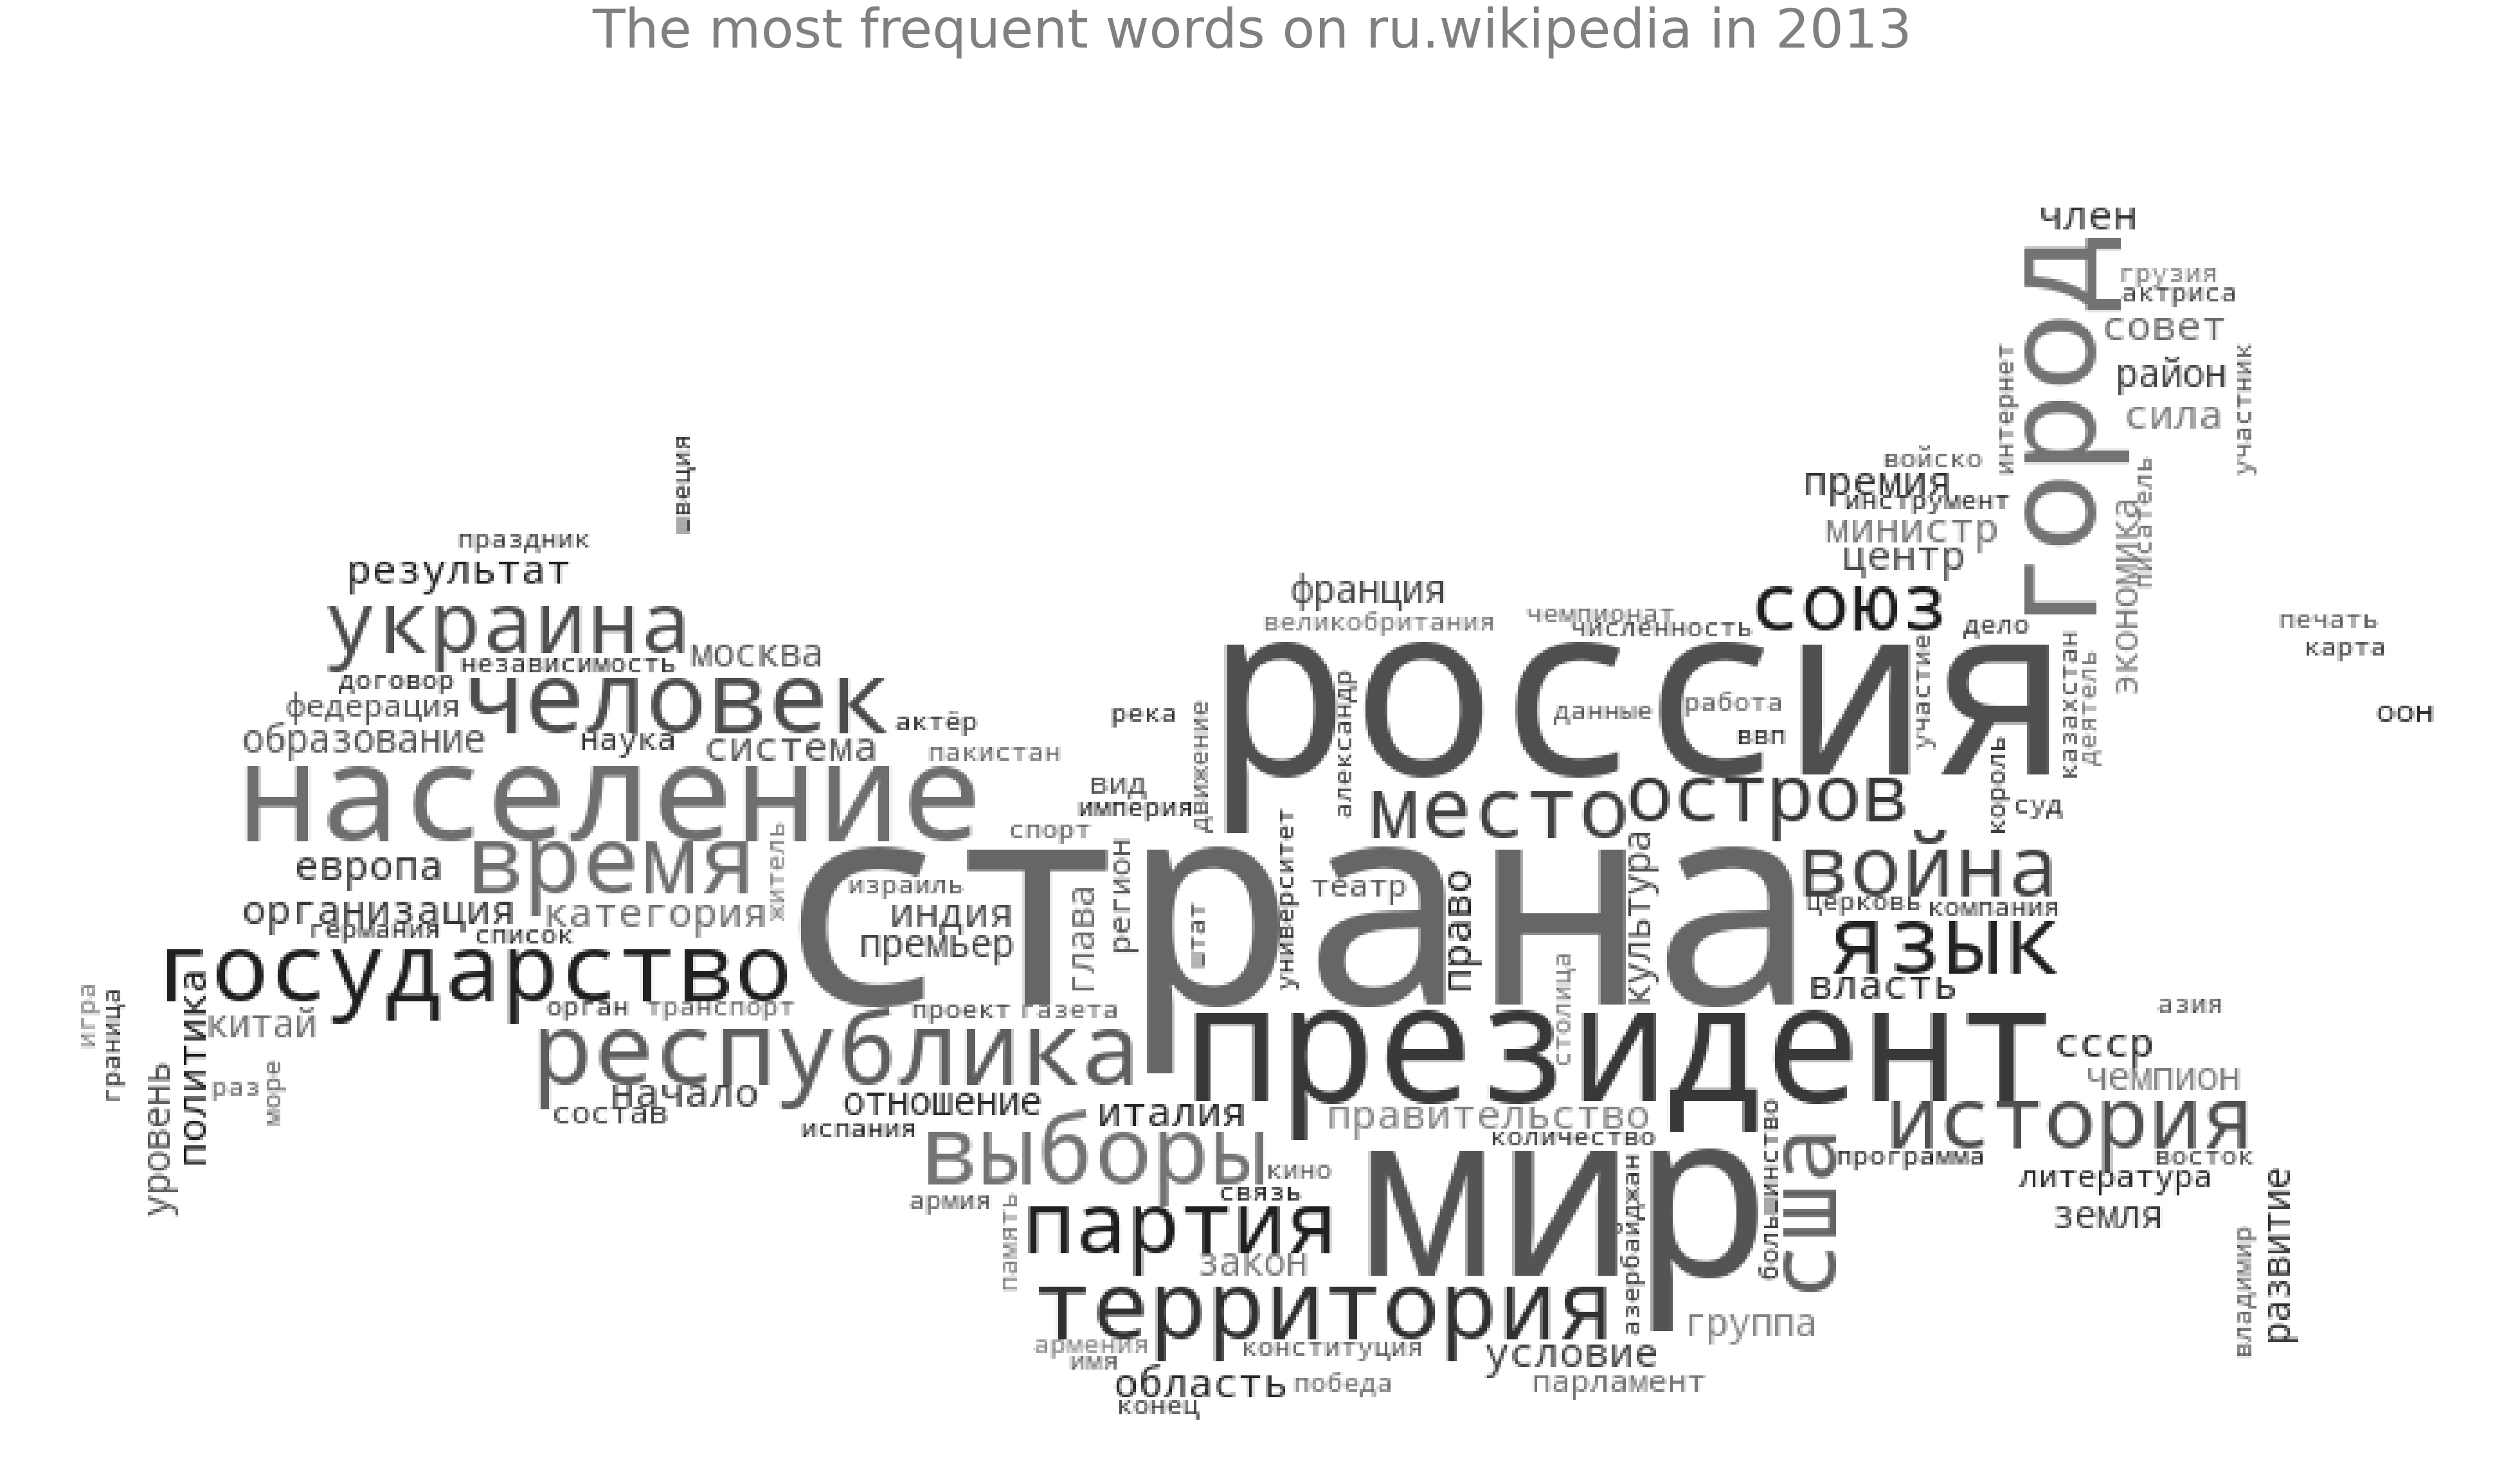

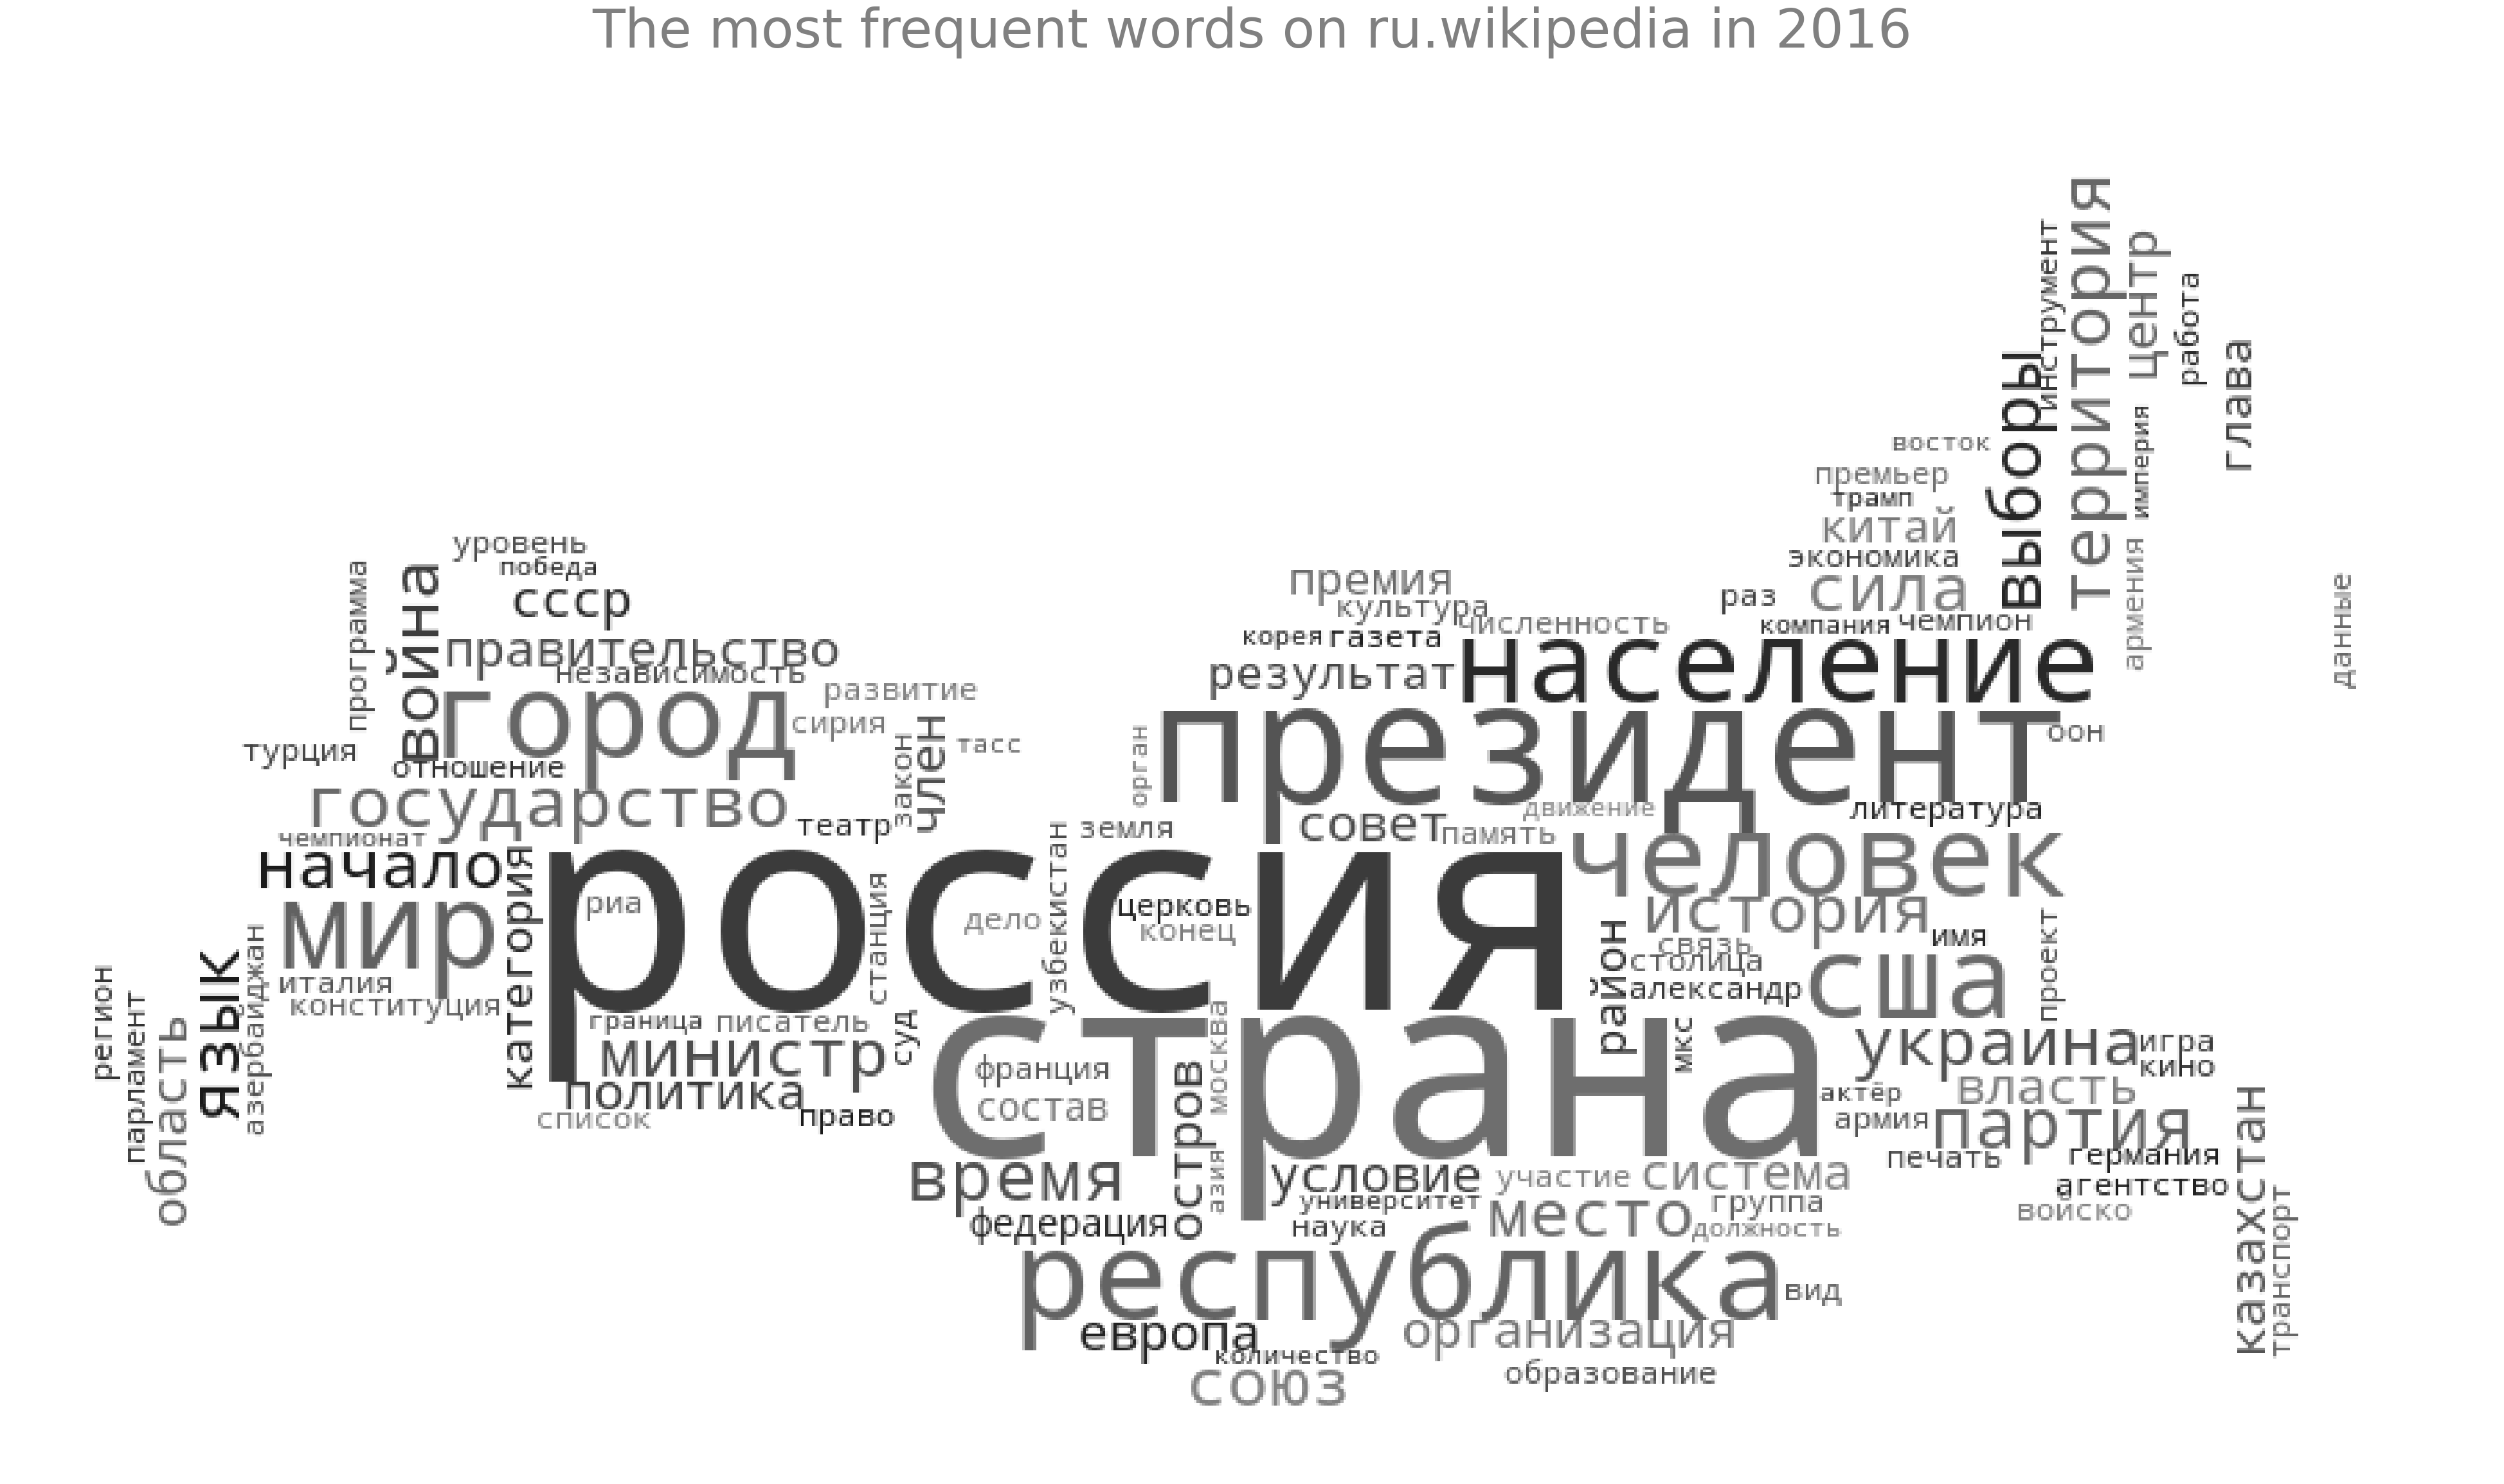

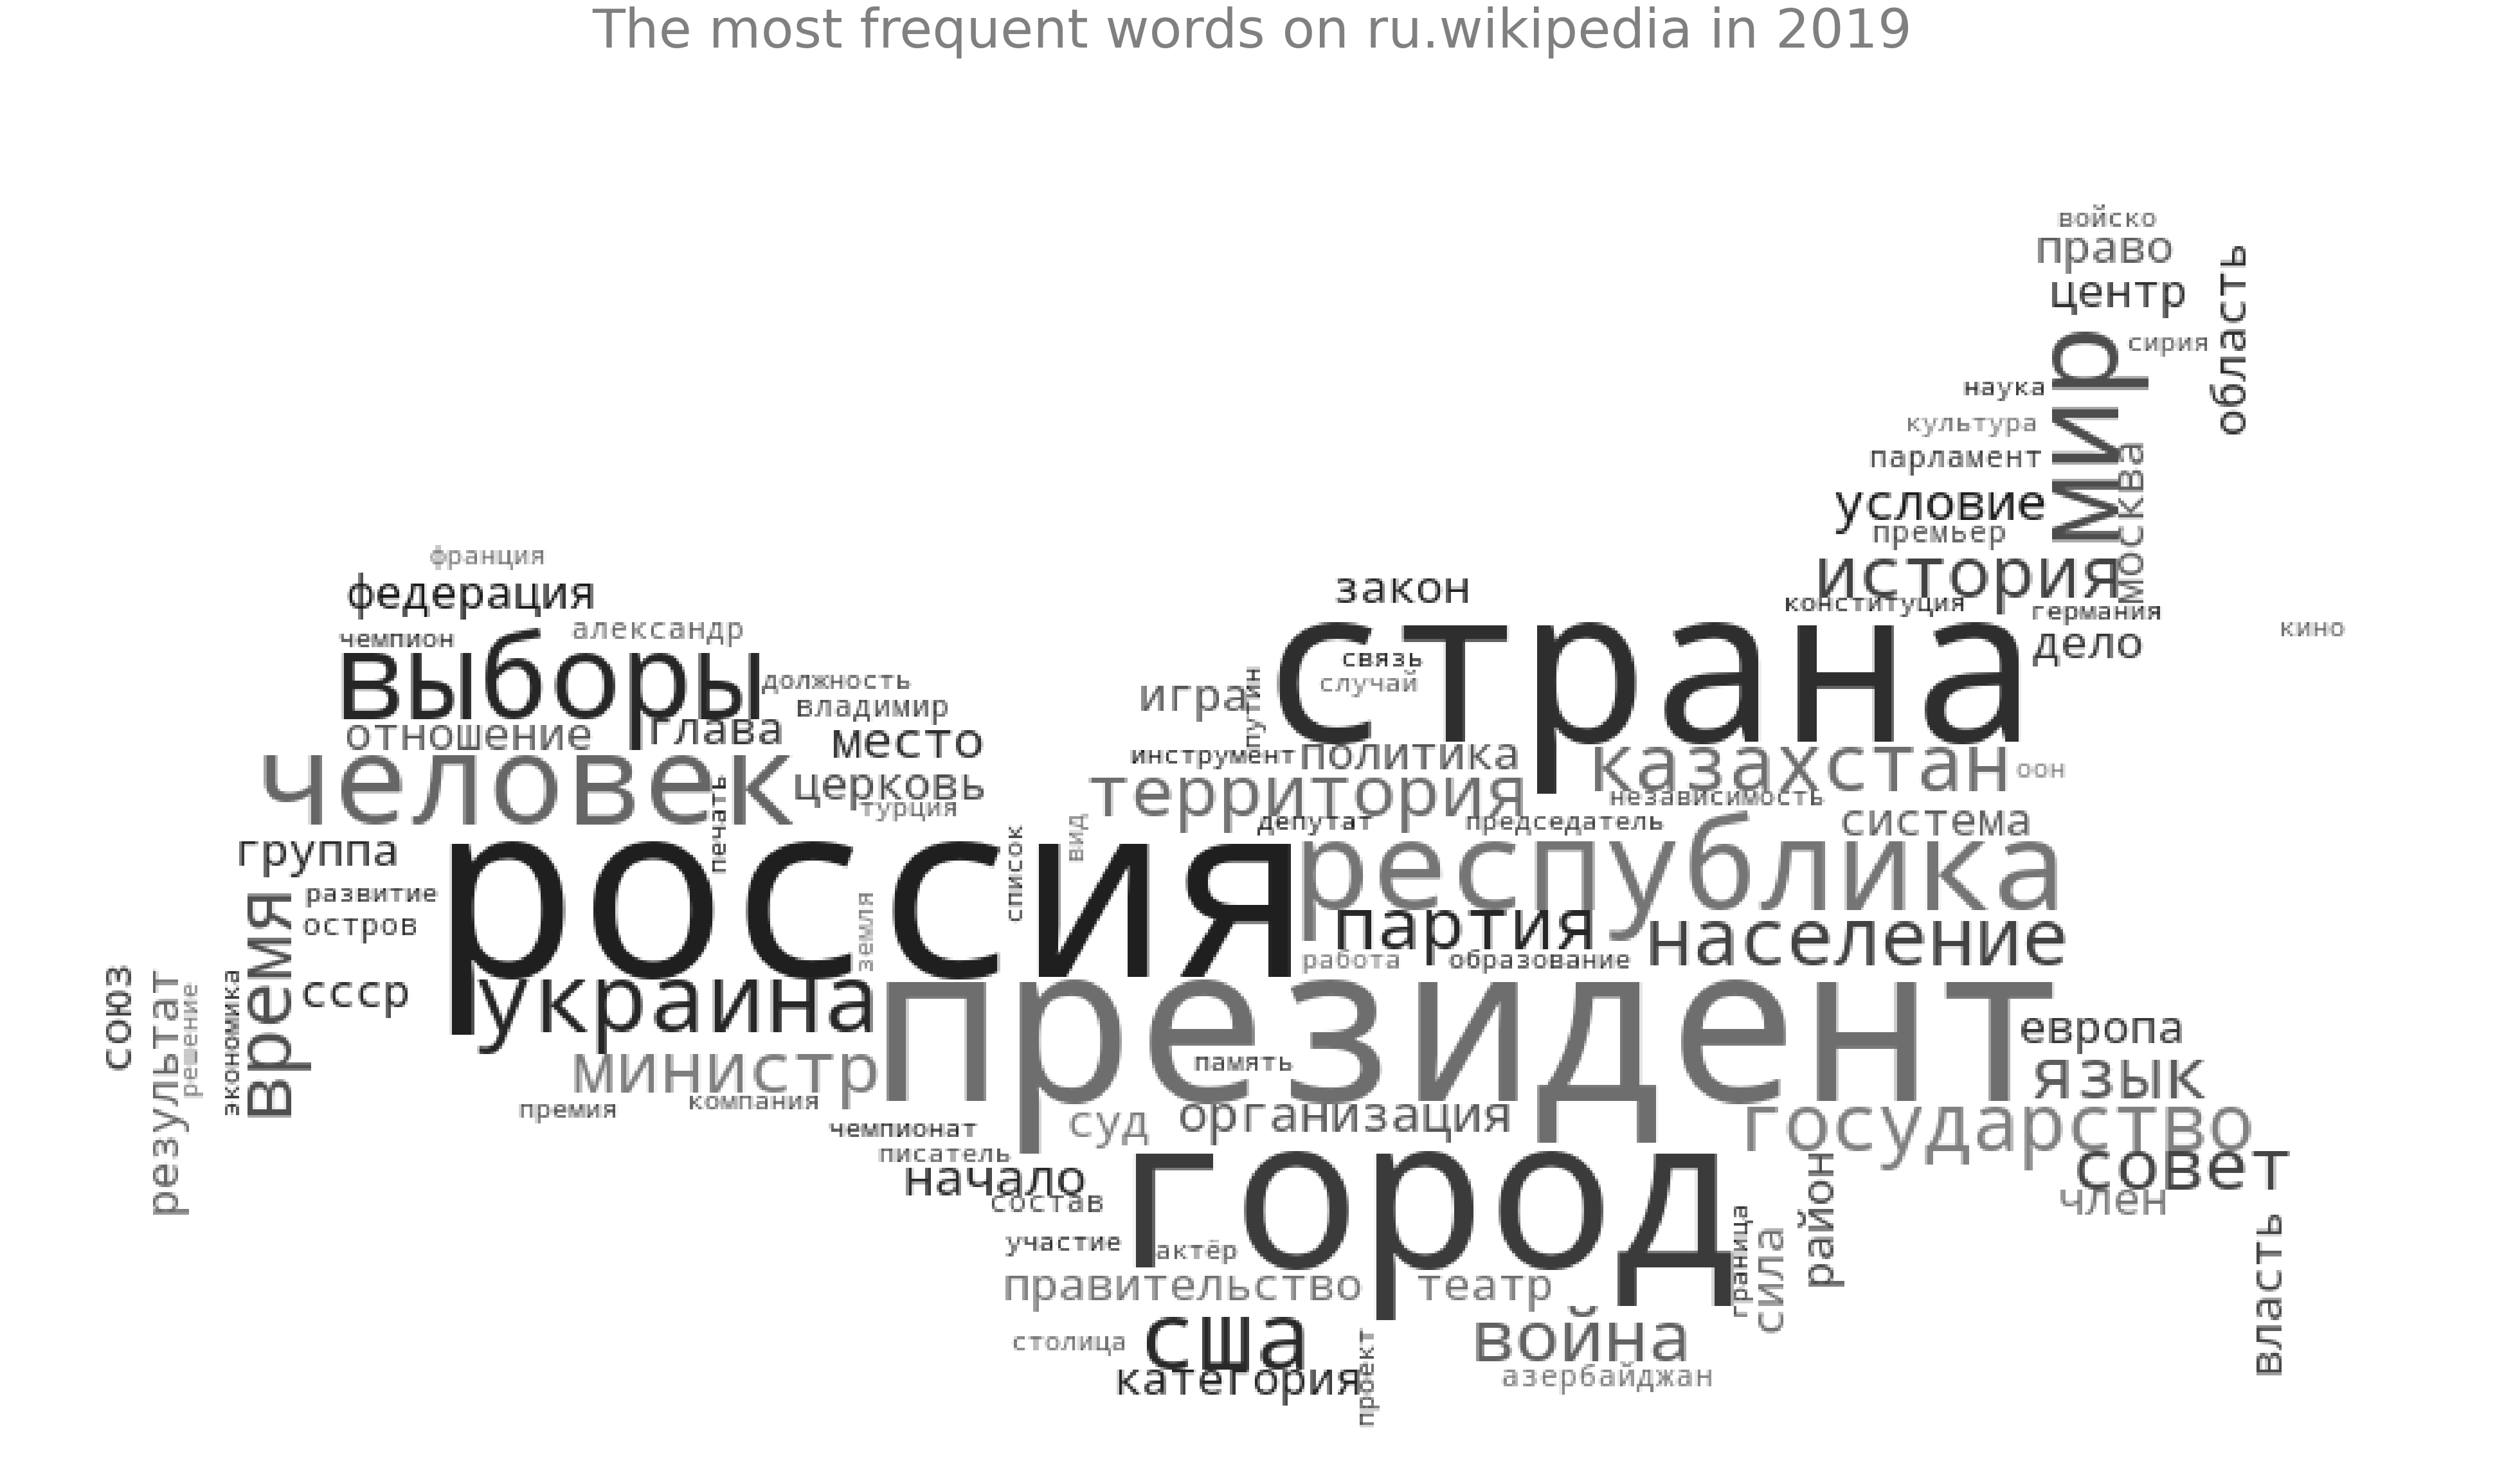

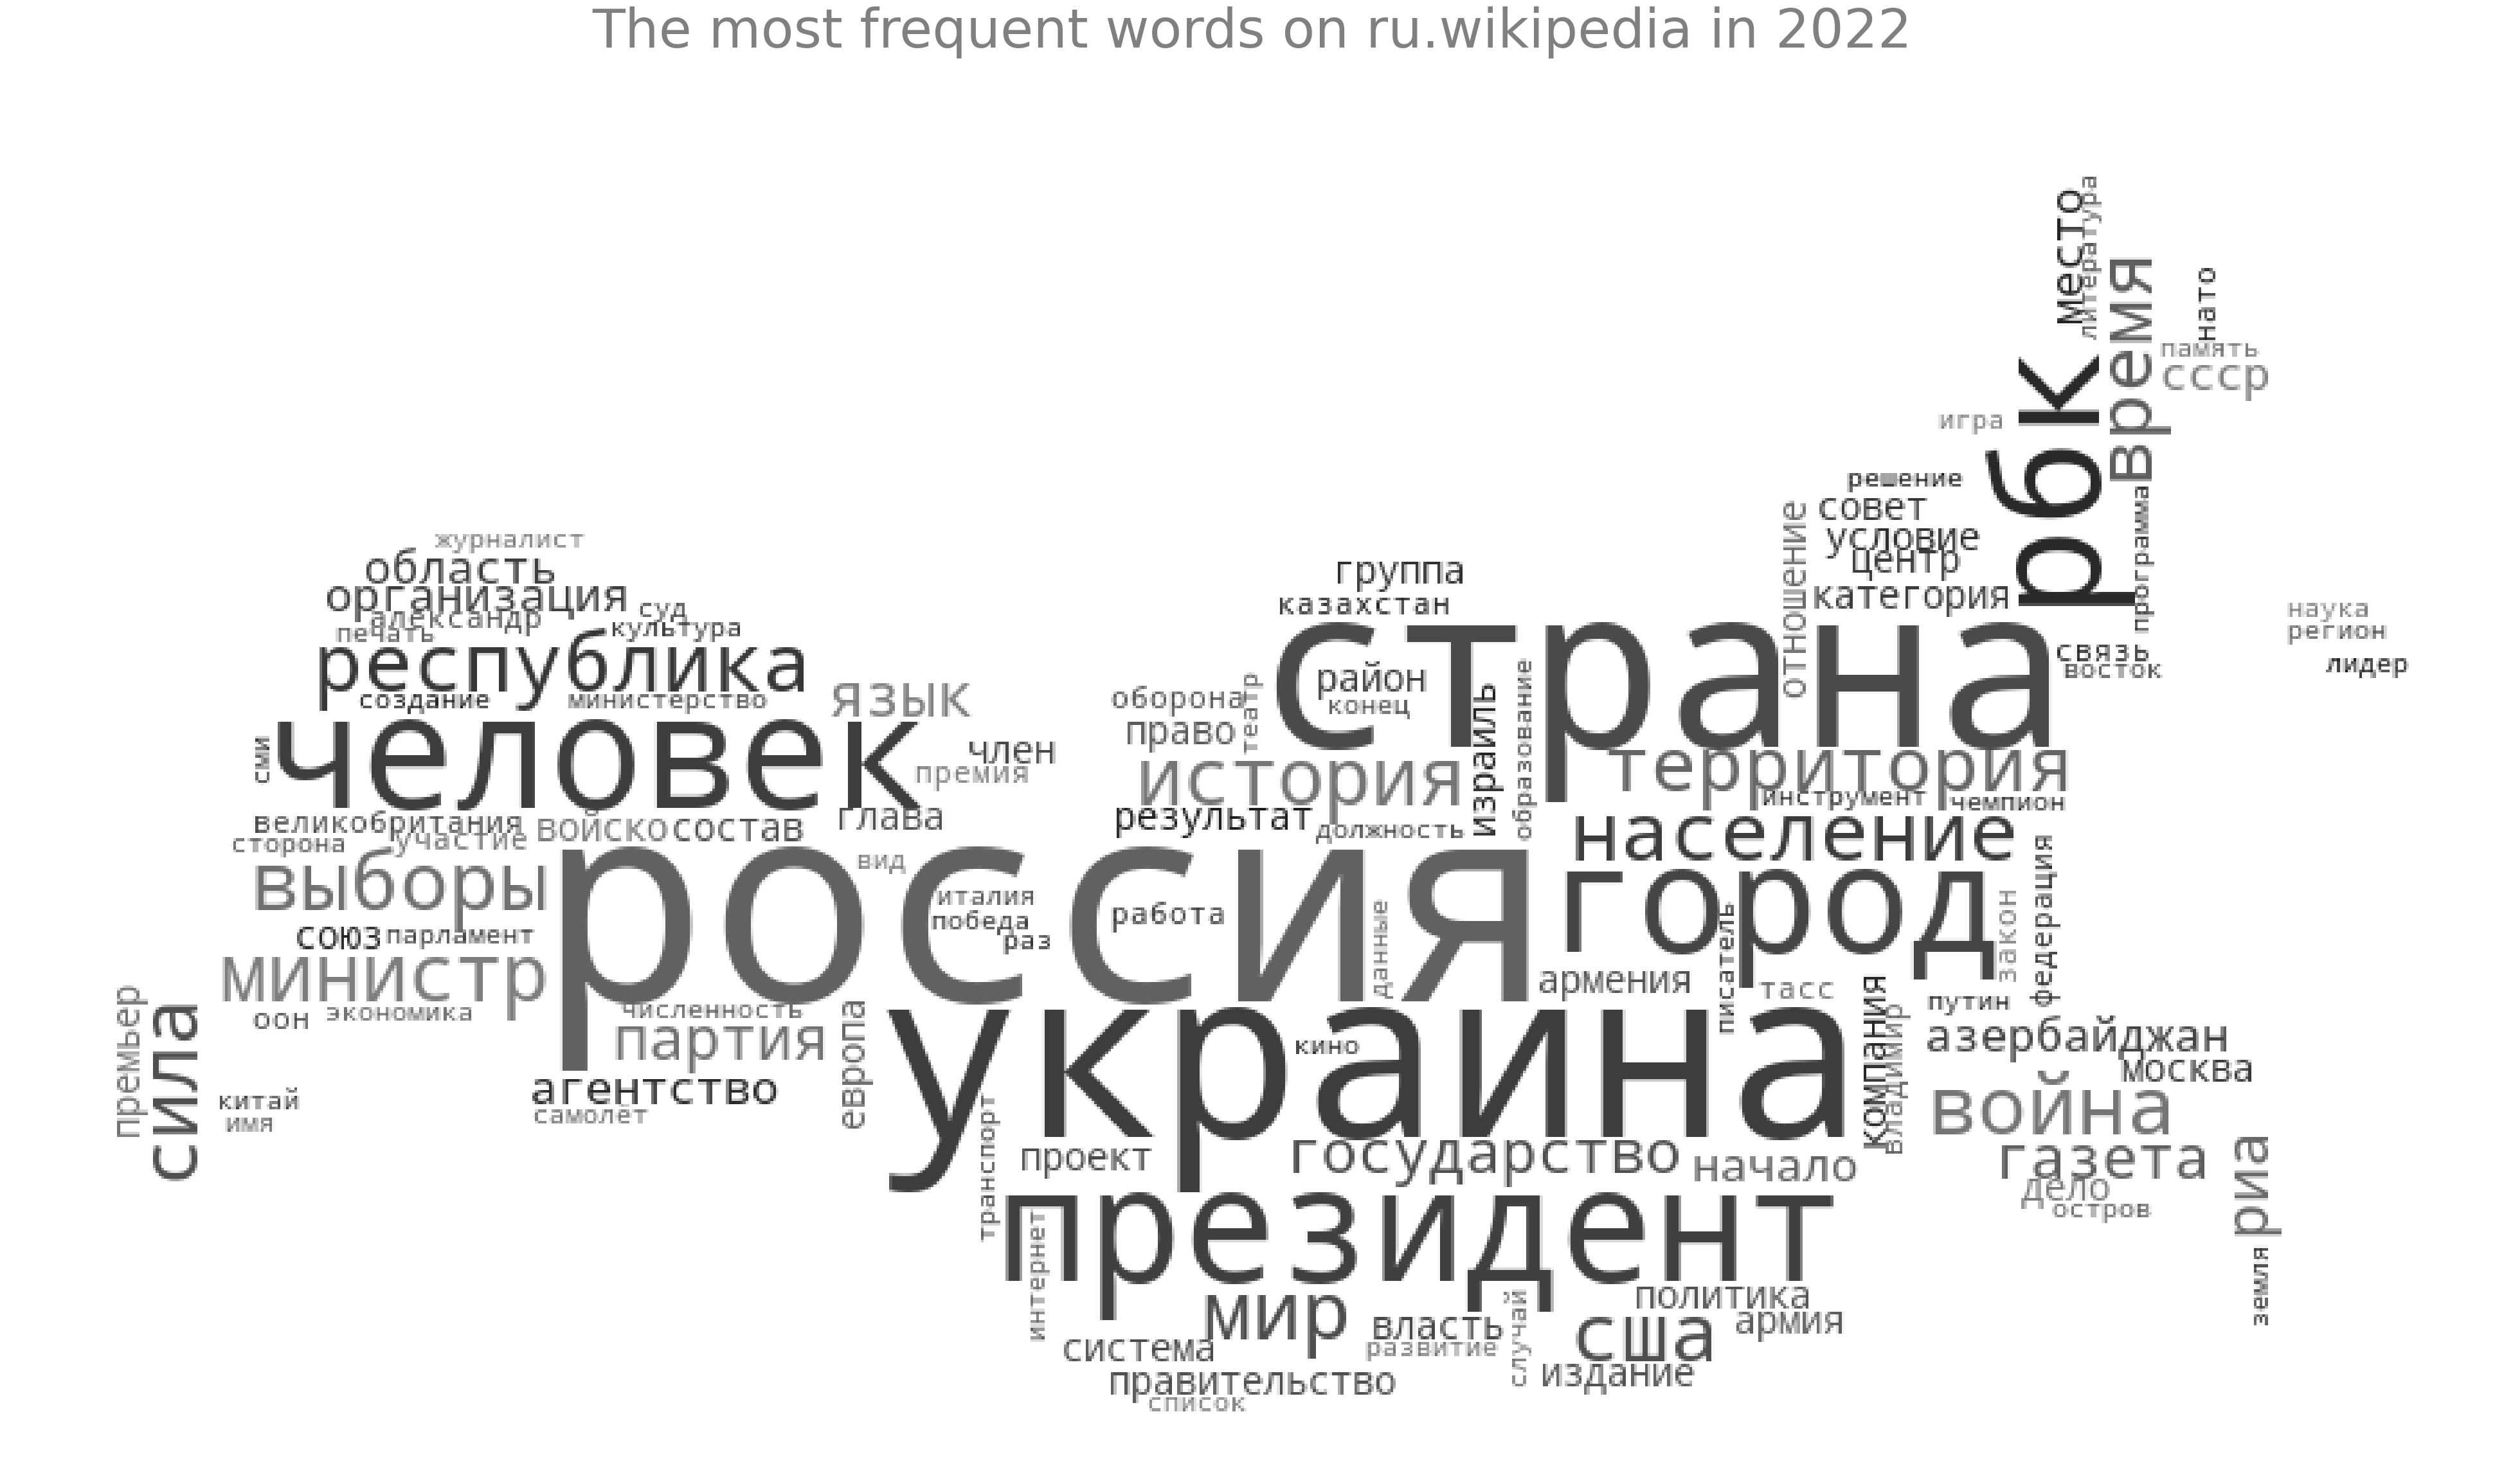

In [374]:
# цвет моджет отвлекать внимание и расставлять неверные акценты, поэтому я буду использовать монохромную палитру. 
# в matplotlob есть цветовая палитра "Grays", но слабая насыщенность делает слова трудно читаемыми, поэтому я воспользуюсь 
# кастомизацией цветов через заданную функцию и метод .recolor()
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(10, 50)

wordcloud1 = WordCloud(width=3000, height=2000, background_color='white', prefer_horizontal=0.8, 
                       margin=2, max_words=300, min_font_size=8, relative_scaling=0.2,
                       collocations=False, mask=maskable_image) \
                       .generate(top_300_string_2013).recolor(color_func=grey_color_func, random_state=-5)
plt.figure(figsize=(50, 40))
plt.axis("off")
plt.title(label='The most frequent words on ru.wikipedia in 2013', fontsize=60, color="gray")
wordcloud1.to_file("wiki_2013.png")
plt.imshow(wordcloud1)

wordcloud2 = WordCloud(width=3000, height=2000, random_state=1, background_color='white', prefer_horizontal=0.8, 
                       margin=2, max_words=300, min_font_size=8, relative_scaling=0.2, colormap='Greys', 
                       collocations=False, mask=maskable_image) \
                       .generate(top_300_string_2016).recolor(color_func=grey_color_func, random_state=-5)
plt.figure(figsize=(50, 40))
plt.axis("off")
plt.title(label='The most frequent words on ru.wikipedia in 2016', fontsize=60, color="gray")
wordcloud2.to_file("wiki_2016.png")
plt.imshow(wordcloud2)

wordcloud3 = WordCloud(width=3000, height=2000, random_state=1, background_color='white', prefer_horizontal=0.8, 
                       margin=2, max_words=300, min_font_size=8, relative_scaling=0.2, colormap='Greys', 
                       collocations=False, mask=maskable_image) \
                       .generate(top_300_string_2019).recolor(color_func=grey_color_func, random_state=-5)
plt.figure(figsize=(50, 40))
plt.axis("off")
plt.title(label='The most frequent words on ru.wikipedia in 2019', fontsize=60, color="gray")
wordcloud2.to_file("wiki_2019.png")
plt.imshow(wordcloud3)


wordcloud4 = WordCloud(width=3000, height=2000, random_state=1, background_color='white', prefer_horizontal=0.8, 
                       margin=2, max_words=300, min_font_size=8, relative_scaling=0.2, colormap='Greys', 
                       collocations=False, mask=maskable_image) \
                       .generate(top_300_string_2022).recolor(color_func=grey_color_func, random_state=-5)
plt.figure(figsize=(50, 40))
plt.axis("off")
plt.title(label='The most frequent words on ru.wikipedia in 2022', fontsize=60, color="gray")
wordcloud3.to_file("wiki_2022.png")
plt.imshow(wordcloud4)

В каждом облаке есть неоспоримые доминанты, такие слова, как "Россия", "страна", "президент" являются самыми часто встречающимися во всех трёх массивах. Но можно увидеть, как слова "мир" и "население" теряют свои позиции, а слова "война" и "Украина" приобретают. В 2022 году стали чаще встречаться слова "сила" и "история". Появляются впервые в топе "риа", "рбк", "агентство" и "газета", "сми", видимо, являясь ссылками на источники информации в статьях. Распределения ТОП 30 из этих 300 слов по каждому году визуально представлены на графиках ниже. Красный столбик означает падение в рейтинге, зелёный — отсутствие снижения рейтинга или его рост, цифры указывают на количество пунктов роста или падения. 

In [389]:
most_common_words_2013['rank'] = most_common_words_2013.frequency.rank(ascending=False)
most_common_words_2016['rank'] = most_common_words_2016.frequency.rank(ascending=False)
most_common_words_2019['rank'] = most_common_words_2019.frequency.rank(ascending=False)
most_common_words_2022['rank'] = most_common_words_2022.frequency.rank(ascending=False)

In [390]:
most_common_words_2013['year'] = 2013
most_common_words_2016['year'] = 2016
most_common_words_2019['year'] = 2019
most_common_words_2022['year'] = 2022

In [411]:
top_30_2013 = most_common_words_2013.head(30)
top_30_2016 = most_common_words_2016.head(30)
top_30_2019 = most_common_words_2019.head(30)
top_30_2022 = most_common_words_2022.head(30)

In [412]:
combined_df = pd.concat([top_30_2013, top_30_2016, top_30_2019, top_30_2022])

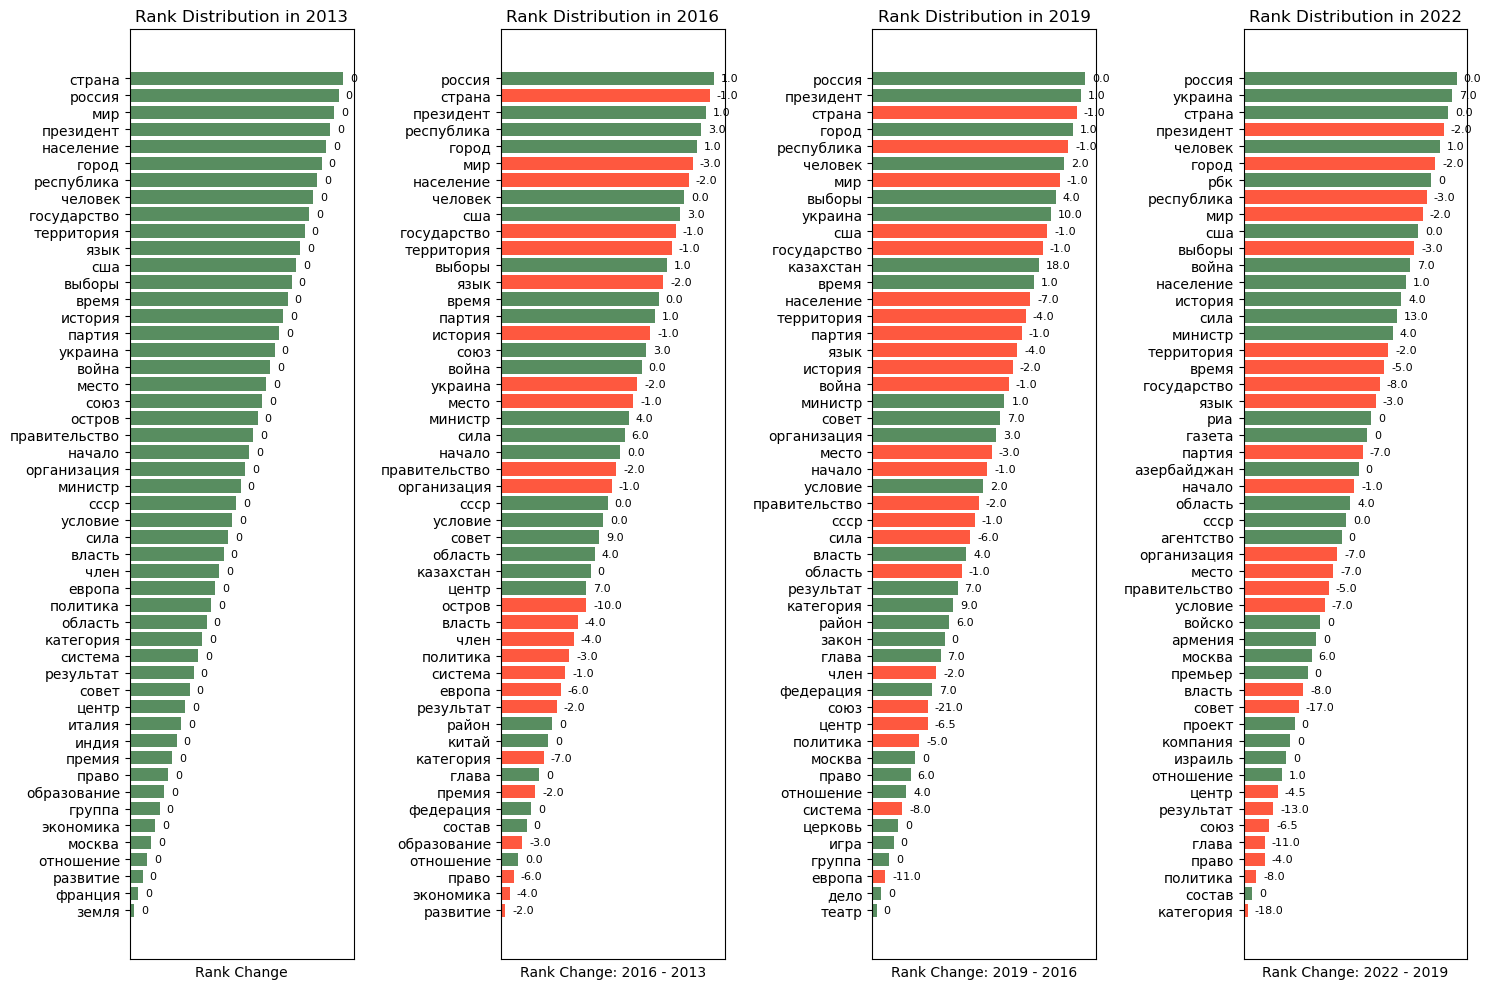

In [420]:
years = combined_df['year'].unique()
num_years = len(years)
fig, axes = plt.subplots(1, num_years, figsize=(15, 10))
previous_rank = {}  #Сохраняю рейтинг за каждый год
for i, year in enumerate(years):
    ax = axes[i]
    year_data = combined_df[combined_df['year'] == year]
    year_data['rank'] = year_data['rank'].astype(int)
    max_rank = max(year_data['rank']) # Рассчитываю максимальный рейтинг за год
    # Переворачиваю ряды (так, чтобы самый низкий ранг оказался вверху), т.к. 1 место у нас имеет самый низкий ранг
    year_data['flipped_rank'] = max_rank + 1 - year_data['rank'].astype(int)
    if year > min(years):
        # Рассчитываю измемения ранга по сравнению с прошлым периодом
        prev_year = year - 3  
        prev_year_data = combined_df[combined_df['year'] == prev_year]
        year_data = year_data.merge(prev_year_data[['word', 'rank']], on='word', how='left', suffixes=('', '_prev'))
        year_data['rank_change'] = year_data['rank_prev'] - year_data['rank']
        # Цвета шкал в зависимости от роста или падения ранга
        colors = ['#588d60' if np.isnan(change) or change == 0 else '#fe583f' if change < 0 else '#588d60' for change in year_data['rank_change']]
    else:
        year_data['rank_change'] = 0
        colors = ['#588d60'] * len(year_data)
    previous_rank[year] = year_data['rank']
    # Строю график в зависимости от ранга и цвета 
    bars = ax.barh(year_data['word'], year_data['flipped_rank'], color=colors)
    ax.set_title(f'Rank Distribution in {year}')
    ax.set_xlabel(f'Rank Change: {year} - {year - 3}' if year > min(years) else 'Rank Change')
    ax.invert_yaxis()  
    # Добавляю в аннотацию к значениям на сколько пунктов изменился ранг
    for bar, change in zip(bars, year_data['rank_change']):
        ax.annotate(f'{change if not np.isnan(change) else 0}', xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                    xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontsize=8)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.set_xticks([]) 
plt.tight_layout()
plt.show()